In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.rand()

def f(x):
   
    return 3*x**2 - 2*x + 1

In [3]:
f(3)

22

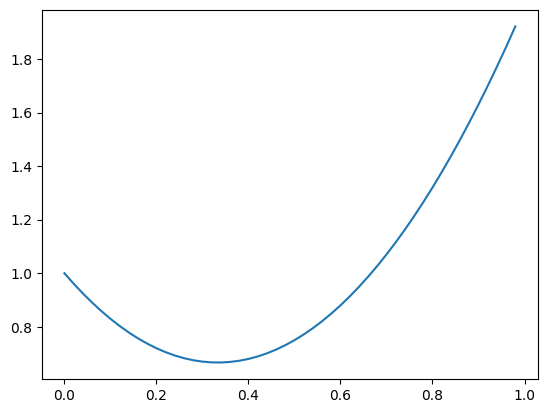

In [4]:
xs = np.arange(0, 1, 0.02)
ys = f(xs)
plt.plot(xs, ys)

From wikipeida:
A function of a real variable $f(x)$ is differentiable at a point $a$ of its domain, if its domain contains an open interval containing $a$ and the limit

$$L = \lim_{h \to 0} \frac{f(a+h)-f(a)}{h}$$


In [5]:
h = 0.0000001
x = -3
(f(x+h) - f(x))/h

-19.99999966528776

In [15]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [16]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__ (self, nin):
        self.weights = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(np.random.uniform(-1, 1))

    def __call__ (self, x):
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.relu()
        return out

    def parameters (self):
        return self.weights + [self.bias]

class Layer(Module):
    def __init__ (self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__ (self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters (self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
    
    def __init__ (self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__ (self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters (self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


x = [1.0, -2.0, 3.0]
n = MLP(3, [4, 4, 1])


In [17]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)          
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='SVG', graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{data %.4f | grad %.4f}" % (n.data, n.grad, ), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
          
    return dot

# Simple Example

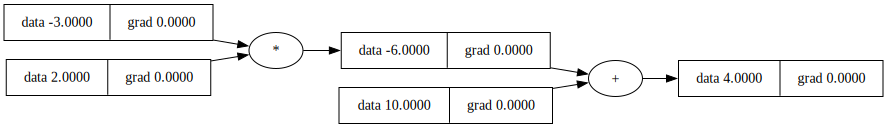

In [18]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

draw_dot(d)

# With Activation function

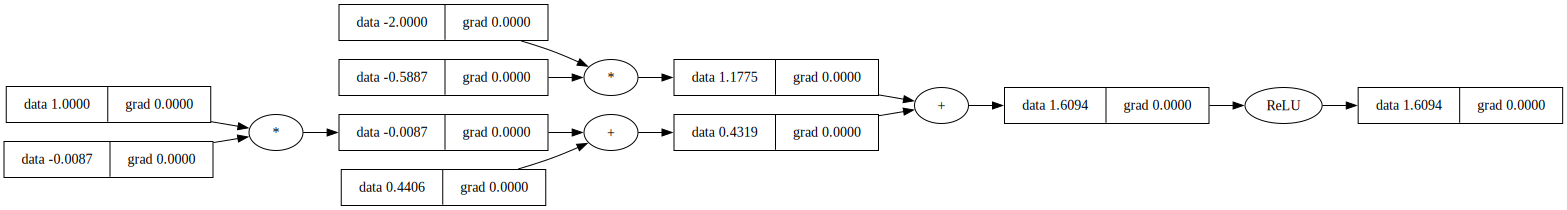

In [19]:
n = Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
dot = draw_dot(y)
dot

# Optimization procedure

In [20]:
xs = [
    [2.0 , 3.0, 5.0],
    [3.0 , -1.0, 0.5],
    [0.5 , 1.0, 1.0],
    [1.0 , 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0 , 1.0]



In [21]:
for k in range(1000):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    n.zero_grad()
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -1 * p.grad

    print(k, loss) if k%100==0 else None

0 Value(data=7.0125678990499996, grad=1)
100 Value(data=4.0, grad=1)
200 Value(data=4.0, grad=1)
300 Value(data=4.0, grad=1)
400 Value(data=4.0, grad=1)
500 Value(data=4.0, grad=1)
600 Value(data=4.0, grad=1)
700 Value(data=4.0, grad=1)
800 Value(data=4.0, grad=1)
900 Value(data=4.0, grad=1)


In [22]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

TypeError: 'Value' object is not callable

In [ ]:
ypred

In [ ]:
n.layers[0].neurons[0].weights[0].data

In [ ]:
n.parameters()

In [ ]:
draw_dot(loss)

## Same procedure in pytorch

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870194532]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
